Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/18 18:52:57 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


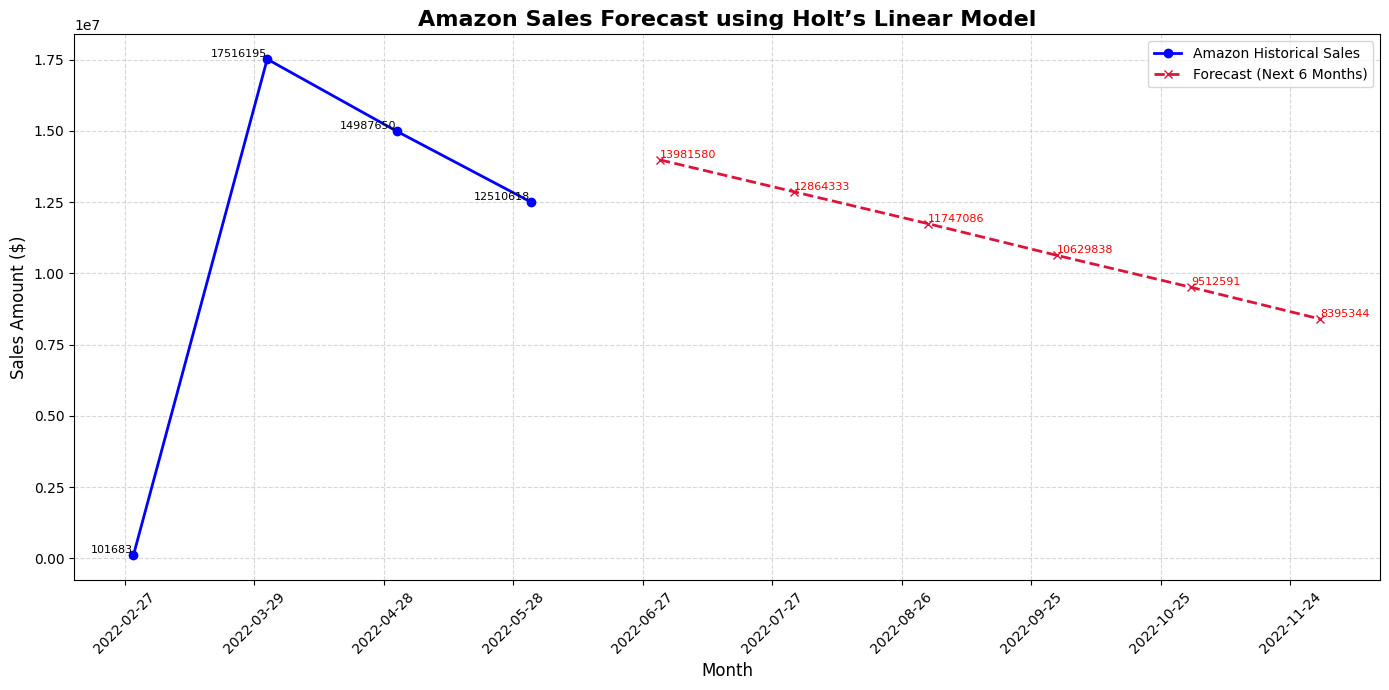

📈 Forecasted Sales for Next 6 Months:
            Forecasted Amount ($)
2022-07-01           1.398158e+07
2022-08-01           1.286433e+07
2022-09-01           1.174709e+07
2022-10-01           1.062984e+07
2022-11-01           9.512592e+06
2022-12-01           8.395345e+06


In [1]:
# =================== 🔹 AMAZON SALES FORECASTING USING PYSPARK + HOLT 🔹 ===================

from pyspark.sql import SparkSession
from pyspark.sql.functions import to_date, col, sum, year, month, regexp_replace
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# =================== Step 1: Initialize Spark Session ===================
spark = SparkSession.builder \
    .appName("AmazonSalesForecast_Holt") \
    .config("spark.driver.extraJavaOptions", "-Dlog4j.logger.org.apache.hadoop.util.NativeCodeLoader=ERROR") \
    .getOrCreate()

# =================== Step 2: Load CSV Data ===================
file_path = "/kaggle/input/amazon-saless/Amazon Sale Report.csv"
df = spark.read.csv(file_path, header=True, inferSchema=True)

# =================== Step 3: Configuration ===================
DATE_COLUMN = "Date"                # Change if your date column has a different name
DATE_FORMAT = "MM-dd-yy"            # Adjust based on the format of your 'Date' column
AMOUNT_COLUMN = "Amount"            # Change if needed

# =================== Step 4: Data Cleaning ===================
df_clean = df.withColumn(
    "parsed_date", to_date(col(DATE_COLUMN), DATE_FORMAT)
).withColumn(
    "clean_amount", regexp_replace(col(AMOUNT_COLUMN), "[^0-9.]", "").cast("double")
).dropna(subset=["parsed_date", "clean_amount"])

# =================== Step 5: Aggregate Monthly Sales ===================
monthly_sales = df_clean.groupBy(
    year("parsed_date").alias("year"),
    month("parsed_date").alias("month")
).agg(
    sum("clean_amount").alias("total_sales")
).orderBy("year", "month")

# =================== Step 6: Convert to Pandas for Forecasting ===================
sales_pd = monthly_sales.toPandas()
sales_pd["date"] = pd.to_datetime(
    sales_pd["year"].astype(str) + "-" + sales_pd["month"].astype(str) + "-01"
)
sales_pd = sales_pd.sort_values("date")
sales_ts = sales_pd.set_index("date")["total_sales"].asfreq('MS')

# =================== Step 7: Apply Holt’s Linear Trend Model ===================
model = ExponentialSmoothing(sales_ts, trend='add', seasonal=None).fit()
forecast = model.forecast(6)  # Forecast next 6 months

# =================== Step 8: Enhanced Visualization ===================
import matplotlib.ticker as ticker

plt.figure(figsize=(14, 7))

# Plot historical sales
plt.plot(sales_ts.index, sales_ts.values, marker='o', label="Amazon Historical Sales", color='blue', linewidth=2)

# Plot forecast
plt.plot(forecast.index, forecast.values, marker='x', linestyle='--', label="Forecast (Next 6 Months)", color='crimson', linewidth=2)

# Add title and labels with larger font
plt.title("Amazon Sales Forecast using Holt’s Linear Model", fontsize=16, fontweight='bold')
plt.xlabel("Month", fontsize=12)
plt.ylabel("Sales Amount ($)", fontsize=12)

# Format X-axis ticks for better readability
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(nbins=12))

# Add grid for better readability
plt.grid(visible=True, linestyle='--', alpha=0.5)

# Add value labels to each point for better insight
for x, y in zip(sales_ts.index, sales_ts.values):
    plt.text(x, y, f'{int(y)}', fontsize=8, ha='right', va='bottom', color='black')
for x, y in zip(forecast.index, forecast.values):
    plt.text(x, y, f'{int(y)}', fontsize=8, ha='left', va='bottom', color='red')

plt.legend()
plt.tight_layout()
plt.show()


# =================== Step 9: Print Forecast ===================
print("📈 Forecasted Sales for Next 6 Months:")
print(forecast.to_frame("Forecasted Amount ($)"))

# =================== Step 10: Stop Spark ===================
spark.stop()

# =================== 🔹 END OF SCRIPT 🔹 ===================


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


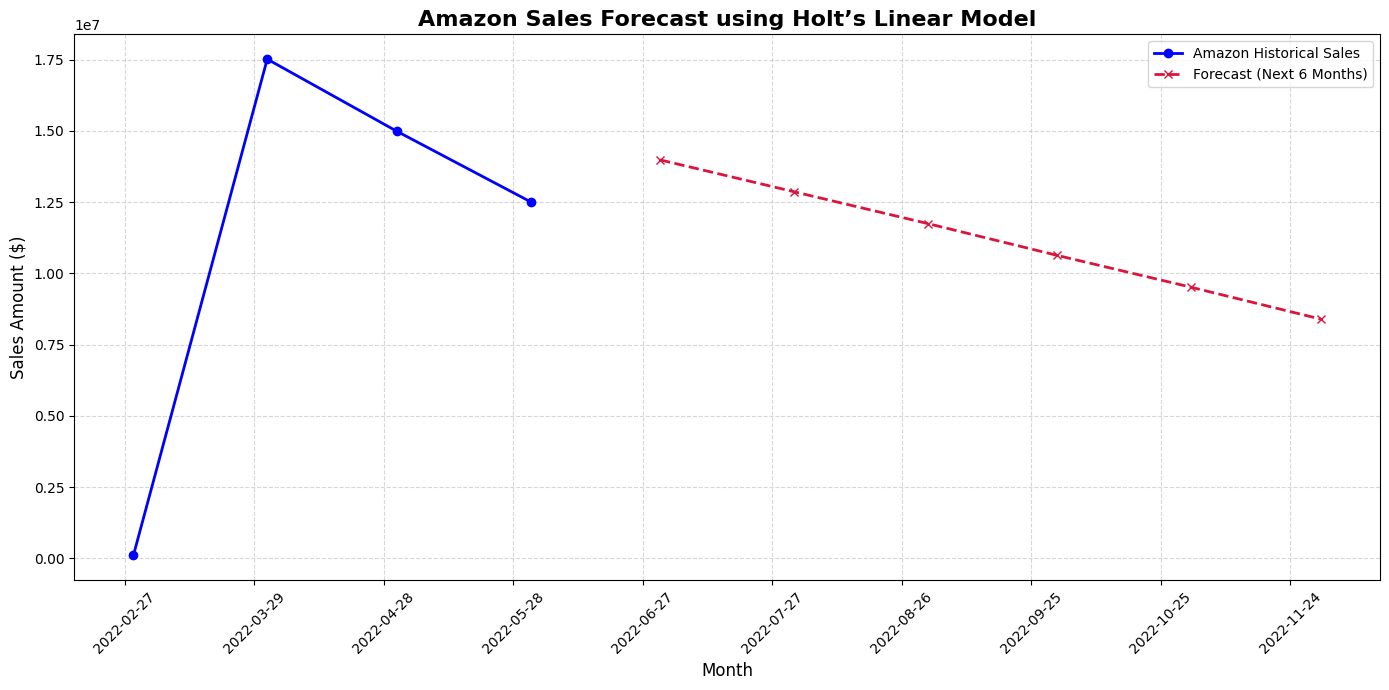

📈 Forecasted Sales for Next 6 Months:
            Forecasted Amount ($)
2022-07-01           1.398158e+07
2022-08-01           1.286433e+07
2022-09-01           1.174709e+07
2022-10-01           1.062984e+07
2022-11-01           9.512592e+06
2022-12-01           8.395345e+06


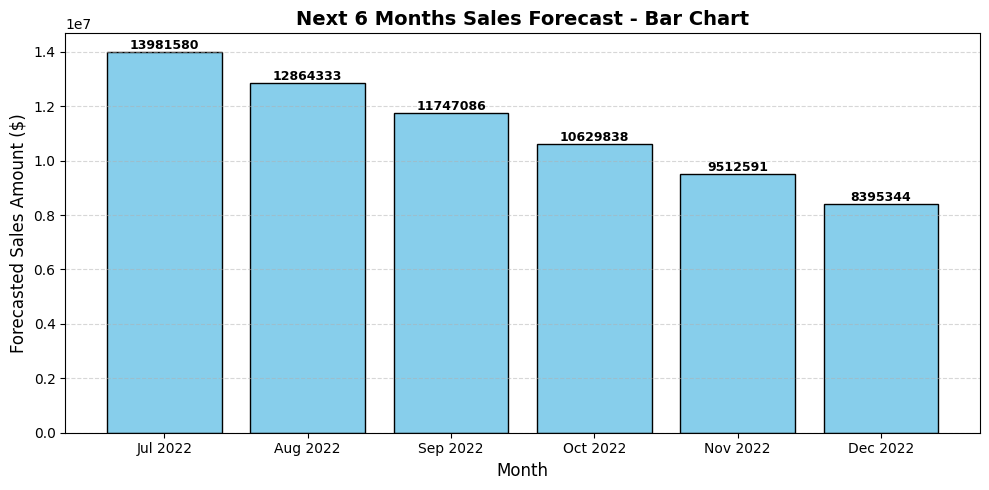

In [2]:
# =================== 🔹 AMAZON SALES FORECASTING USING PYSPARK + HOLT + BAR CHART 🔹 ===================

from pyspark.sql import SparkSession
from pyspark.sql.functions import to_date, col, sum, year, month, regexp_replace
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.ticker as ticker

# =================== Step 1: Initialize Spark Session ===================
spark = SparkSession.builder \
    .appName("AmazonSalesForecast_Holt") \
    .config("spark.driver.extraJavaOptions", "-Dlog4j.logger.org.apache.hadoop.util.NativeCodeLoader=ERROR") \
    .getOrCreate()

# =================== Step 2: Load CSV Data ===================
file_path = "/kaggle/input/amazon-saless/Amazon Sale Report.csv"
df = spark.read.csv(file_path, header=True, inferSchema=True)

# =================== Step 3: Configuration ===================
DATE_COLUMN = "Date"                
DATE_FORMAT = "MM-dd-yy"            
AMOUNT_COLUMN = "Amount"

# =================== Step 4: Data Cleaning ===================
df_clean = df.withColumn(
    "parsed_date", to_date(col(DATE_COLUMN), DATE_FORMAT)
).withColumn(
    "clean_amount", regexp_replace(col(AMOUNT_COLUMN), "[^0-9.]", "").cast("double")
).dropna(subset=["parsed_date", "clean_amount"])

# =================== Step 5: Aggregate Monthly Sales ===================
monthly_sales = df_clean.groupBy(
    year("parsed_date").alias("year"),
    month("parsed_date").alias("month")
).agg(
    sum("clean_amount").alias("total_sales")
).orderBy("year", "month")

# =================== Step 6: Convert to Pandas for Forecasting ===================
sales_pd = monthly_sales.toPandas()
sales_pd["date"] = pd.to_datetime(
    sales_pd["year"].astype(str) + "-" + sales_pd["month"].astype(str) + "-01"
)
sales_pd = sales_pd.sort_values("date")
sales_ts = sales_pd.set_index("date")["total_sales"].asfreq('MS')

# =================== Step 7: Apply Holt’s Linear Trend Model ===================
model = ExponentialSmoothing(sales_ts, trend='add', seasonal=None).fit()
forecast = model.forecast(6)  # Forecast next 6 months

# =================== Step 8: Line Chart Visualization ===================
plt.figure(figsize=(14, 7))
plt.plot(sales_ts.index, sales_ts.values, marker='o', label="Amazon Historical Sales", color='blue', linewidth=2)
plt.plot(forecast.index, forecast.values, marker='x', linestyle='--', label="Forecast (Next 6 Months)", color='crimson', linewidth=2)
plt.title("Amazon Sales Forecast using Holt’s Linear Model", fontsize=16, fontweight='bold')
plt.xlabel("Month", fontsize=12)
plt.ylabel("Sales Amount ($)", fontsize=12)
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(nbins=12))
plt.grid(visible=True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

# =================== Step 9: Print Forecast ===================
print("📈 Forecasted Sales for Next 6 Months:")
print(forecast.to_frame("Forecasted Amount ($)"))

# =================== Step 10: 📊 Bar Chart for Forecasted Sales ===================
forecast_df = forecast.to_frame("Forecasted Amount ($)")
forecast_df.reset_index(inplace=True)

plt.figure(figsize=(10, 5))
bars = plt.bar(forecast_df['index'].dt.strftime('%b %Y'), forecast_df["Forecasted Amount ($)"], color='skyblue', edgecolor='black')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{int(height)}', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.title("Next 6 Months Sales Forecast - Bar Chart", fontsize=14, fontweight='bold')
plt.xlabel("Month", fontsize=12)
plt.ylabel("Forecasted Sales Amount ($)", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# =================== Step 11: Stop Spark ===================
spark.stop()

# =================== 🔹 END OF SCRIPT 🔹 ===================
